<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC3</p>
<p style="margin: 0; text-align:right;">2019-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Mètodes supervisats

En aquesta pràctica veurem diferents mètodes supervisats aplicats sobre el conjunt de dades [MOONS](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) (dataset de `scikit-learn`) i tractarem d'optimitzar diferents mètriques. Veurem com els diferents models classifiquen els punts i amb quins obtenim major precisió.

<ol start="0">
  <li>Càrrega de dades</li>
  <li>$k$ veïns més propers</li>
  <li>Support vector machines</li>
  <li>Arbre de decisió</li>
  <li>Random forest</li>
  <li>Gradient boosting</li>
  <li>Xarxes neuronals</li>
</ol>

**Important: Cadascun dels exercicis pot suposar varios minuts d'execució, pel que l'entrega s'ha de fer en format notebook i en format html on es vegi el codi i els resultats, juntament amb els comentaris de cada exercici. Per a exportar el notebook a html es pot fer des del menú File $\to$ Download as $\to$ HTML.**

## 0. Càrrega de dades

El conjunt de dades MOONS consisteix en punts en un pla que formen dues llunes, d'aquí el nom de "moons". Cada lluna correspon a un grup diferent [0, 1].

El següent codi generara 1.000 punts i en farà un gràfic per visualitzar les dues llunes (amb colors diferents per cada grup).

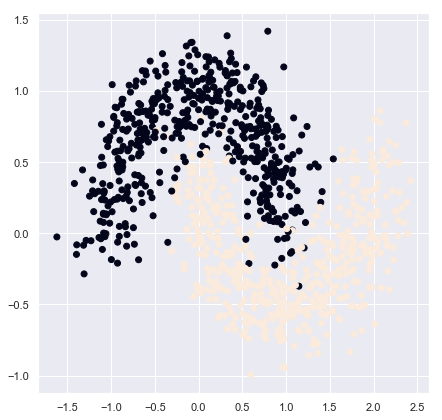

In [207]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap
%matplotlib inline

df = make_moons(n_samples=1000, noise=0.2, random_state=2)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group)

Abans d'aplicar cap model, hem de separar les dades entre el conjunt de *train* i el conjunt de *test*. Sempre treballarem sobre el conjunt de *train* i evaluarem els resultats en *test*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong> Dividiu el <i>dataset</i> en dos subconjunts, <i>train</i> (80% aprox.) i <i>test</i>. Podeu fer servir l'implementació train_test_split de sklearn.
</div>

In [208]:
from sklearn.model_selection import train_test_split

# Obtenim les dades
df_data = df[0]

# Obtenim el conjunt de test i d'entrenament
x_train, x_test, y_train, y_test = train_test_split(df_data, df_group, test_size = 0.2, random_state=None)

Al llarg dels exercicis apendrem a veure gràficament les fronteres de decisió que ens retornen els diferents models. Per fer això utilitzarem la funció definida a continuació. Aquesta segueix els següents passos:

- Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) amb els valors mínim i màxim de 'x' i 'y'.
- Predir el classificador amb els valors de la *meshgrid*.
- Fer un *reshape* de les dades per tenir el format corresponent.

Un cop fet això ja podem fer el gràfic de les fronteres de decisió i afegir-hi els punts reals.
Així veurem les àrees que el model considera que són d'una classe i les que considera que són d'una altre. Al posar-hi a sobre els punts veurem si els classifica correctament a l'àrea que els correspon.

In [233]:
# Fem la meshgrid amb els valors màxim i mínim de 'x' i 'y'.
x_min, x_max = df[0].min()-0.1, df[0].max()+0.1
y_min, y_max = df[1].min()-0.1, df[1].max()+0.1  

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Predim el classifier amb els valors de la meshgrid.
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Fem reshape per tenir el format correcte.
    Z = Z.reshape(xx.shape)

    # Seleccionem una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Fem el gràfic de les fronteres de decisió.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap)
    
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

## 1. $k$ veïns més propers (1 punt)

El primer algoritme que utilitzarem per a classificar els punts és el $k$-nn. En aquest exercici ajustarem dos hiperparàmetres del algoritme per tal d'intentar obtenir una major precisió:

- $k$: el número de veïns que es consideren per a classificar un nou exemple. Provarem amb tots els valors entre 1 i 10.
- pesos: importància que es dona a cadascun dels veïns considerats. En aquest cas provarem amb dues opcions: pesos uniformes, on tots els veïns es consideren igual; i pesos segons distància, on els veïns més propers tenen més pes en la classificació que els veïns més llunyans.

Per a decidir quins són els hiperparàmetres òptims utilitzarem una cerca de reixeta (*grid search*), és a dir, entrenarem un model per a cada combinació de hiperparàmetres possible i l'evaluarem utilitzant validació creuada (*cross validation*) amb 4 particions estratificades. Posteriorment, triarem la combinació d'hiperparàmetres que millors resultats hagi obtingut.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong> càlcul del valor òptim dels hiperparàmetres <i>k</i> i <i>pesos</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i KNeighborsClassifier de sklearn.
</div>

In [209]:
# Calculem els valors depenent de k (entre 1 i 10) amb pes uniforme i valorant la distància

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import seaborn as sns 
import warnings

warnings.filterwarnings("ignore")
sns.set()

clf = KNeighborsClassifier()
sns.set()
def evaluate(k, weight, x_train, y_train, x_test, y_test):
    param_grid = {"n_neighbors": [k], "weights": [weight]}    
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=4)
    grid_search.fit(x_train, y_train)
    y_true, y_pred = y_test, grid_search.predict(x_test)
    scores = cross_val_score(grid_search, x_test, y_test, verbose=0, cv=4)
    return scores
    
tabla_aval_uniform = []    
for k in range(1,11):        
    aval = evaluate(k, "uniform", x_train, y_train, x_test, y_test)
    print('weight: uniform  - k: '+ str(k) + ' - ' + str(aval))
    tabla_aval_uniform.append(aval)  
    
print('--------------------------------------------------------------------')

tabla_aval_distance = []        
for k in range(1,11):        
    aval = evaluate(k, "distance", x_train, y_train, x_test, y_test)
    print('weight: distance  - k: '+ str(k) + ' - ' + str(aval))
    tabla_aval_distance.append(evaluate(k, "distance", x_train, y_train, x_test, y_test))
    
print('--------------------------------------------------------------------')    

weight: uniform  - k: 1 - [0.96078431 0.94       0.98       0.93877551]
weight: uniform  - k: 2 - [0.96078431 0.92       0.98       0.93877551]
weight: uniform  - k: 3 - [0.96078431 0.96       1.         0.97959184]
weight: uniform  - k: 4 - [0.96078431 0.96       1.         0.97959184]
weight: uniform  - k: 5 - [0.96078431 0.98       0.98       0.97959184]
weight: uniform  - k: 6 - [0.96078431 0.96       1.         0.97959184]
weight: uniform  - k: 7 - [0.96078431 0.96       0.98       0.97959184]
weight: uniform  - k: 8 - [0.96078431 0.96       1.         0.97959184]
weight: uniform  - k: 9 - [0.96078431 0.96       1.         0.97959184]
weight: uniform  - k: 10 - [0.96078431 0.96       1.         0.97959184]
--------------------------------------------------------------------
weight: distance  - k: 1 - [0.96078431 0.94       0.98       0.93877551]
weight: distance  - k: 2 - [0.96078431 0.94       0.98       0.93877551]
weight: distance  - k: 3 - [0.96078431 0.94       1.         0.9

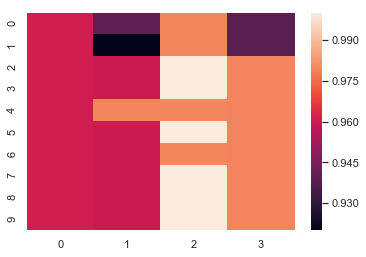

In [210]:
# HeatMap de weight uniform
sns.heatmap(tabla_aval_uniform)

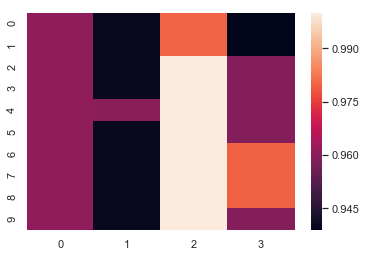

In [211]:
# HeatMap de weight distance
sns.heatmap(tabla_aval_distance)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

In [213]:
print('--------------------------------------------------------------------')
print('diferències entre pesos')
print('--------------------------------------------------------------------')
for i in range(1, 10):
    print(tabla_aval_distance[i] - tabla_aval_uniform[i])
    total = 0
 
print('--------------------------------------------------------------------')
print('diferències entre k per a pes uniforme')
print('--------------------------------------------------------------------')    
for i in range(1,9):
    print(tabla_aval_uniform[i] - tabla_aval_uniform[i-1])    

print('--------------------------------------------------------------------')
print('diferències entre k per a pes distàncies')
print('--------------------------------------------------------------------')    
for i in range(1, 10):
    print(tabla_aval_distance[i] - tabla_aval_distance[i-1])
        
# Com es pot veure a les dades:
#   - La majoria dels punts està sempre ben classificat a tots els casos. Això és perque els dos conjunts estan força
#     separats. Només són conflictius els punts propers a les dues regions.
#   - Depenent de l'execució, tenim unes dades o unes altres. A l'execusió presentada podem veure que la variació
#     augmentant k és molt petita; com a pes, es comporta millor el model uniforme.
#   - No sembla que hi hagi cap combinació molt millor que una altra.
#   - Jo esperava que el model afegint la distància es comportés millor que el que no. 
#   - Sembla que la millor combinació és k = 2 i pes = uniforme

--------------------------------------------------------------------
diferències entre pesos
--------------------------------------------------------------------
[0.   0.02 0.   0.  ]
[ 0.         -0.02        0.         -0.02040816]
[ 0.         -0.02        0.         -0.02040816]
[ 0.         -0.02        0.02       -0.02040816]
[ 0.         -0.02        0.         -0.02040816]
[ 0.   -0.02  0.02  0.  ]
[ 0.   -0.02  0.    0.  ]
[ 0.   -0.02  0.    0.  ]
[ 0.         -0.02        0.         -0.02040816]
--------------------------------------------------------------------
diferències entre k per a pes uniforme
--------------------------------------------------------------------
[ 0.   -0.02  0.    0.  ]
[0.         0.04       0.02       0.04081633]
[0. 0. 0. 0.]
[ 0.    0.02 -0.02  0.  ]
[ 0.   -0.02  0.02  0.  ]
[ 0.    0.   -0.02  0.  ]
[0.   0.   0.02 0.  ]
[0. 0. 0. 0.]
--------------------------------------------------------------------
diferències entre k per a pes distàncies
-

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el <i>dataset</i> de test, i calculeu l'<i>accuracy</i> i la matriu de confusió. 
</div>

Accuracy: 0.955


array([[95,  2],
       [ 7, 96]], dtype=int64)

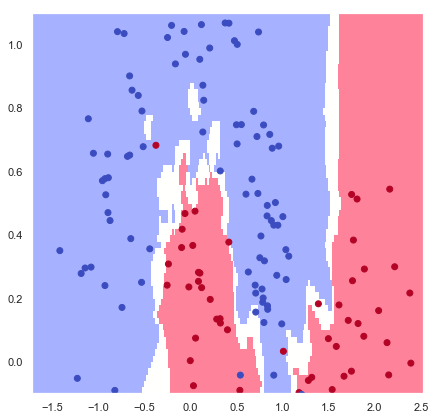

In [251]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Podem veure la frontera de decisió
param_grid = {"n_neighbors": [2], "weights": ["uniform"]} 
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=4)
grid_search.fit(x_train, y_train)
plot_decision_boundaries(x_test[:,0], x_test[:,1], y_test, grid_search)

# Obtenim l'accuracy; podem veure que és superior al 95%
y_pred = grid_search.predict(x_test)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

# Podem veure a la matriu de confusió com només 9 elements de 200 han estat clasificats de forma incorrecta
confusion_matrix(y_test, y_pred)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

In [252]:
# La frontera de decisió estableix d'una forma molt acurada la separació entre les clases del subconjunt de test
# La classificació és bastant bona, tenint en compte que només considerem els dos veïnats més propers
# Classifiquem correctament 191 valors de 200 (un 95.5%)

## 2. Support Vector Machines (1 punt)

En aquest segon exercici classificarem els punts utilitzant l'algoritme SVM amb el *kernel* radial. Tornarem a utilitzar una cerca de reixeta (*grid search*). En aquest cas els hiperparàmetres a optimitzar són:

- C: és la regularització, és a dir, el valor de penalització dels errors en la classificació. Indica el compromís entre obtenir l'hiperpla amb el marge més gran possible i classificar el màxim número d'exemples correctament. Provarem els valors: 0.01, 0.1, 1, 10, 50, 100 i 200.
- gamma: coeficient que multiplica la distància entre dos punts al kernel radial. Per dir-ho a "grosso modo", com més petit és gamma, més influencia tenen dos punts propers. Provarem els valors: 0.001, 0.01, 0.1, 1 i 10.

Igual que en el cas anterior, per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>C</i> i <i>gamma</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòdul GridSearchCV i svm de sklearn.
</div>

c: 0.01 g: 0.001 --> [0.50980392 0.52       0.52       0.51020408]
c: 0.01 g: 0.01 --> [0.50980392 0.52       0.52       0.51020408]
c: 0.01 g: 0.1 --> [0.50980392 0.52       0.52       0.51020408]
c: 0.01 g: 1 --> [0.50980392 0.52       0.52       0.51020408]
c: 0.01 g: 10 --> [0.50980392 0.52       0.52       0.51020408]
c: 0.1 g: 0.001 --> [0.96078431 0.96       0.88       0.97959184]
c: 0.1 g: 0.01 --> [0.96078431 0.96       0.88       0.97959184]
c: 0.1 g: 0.1 --> [0.96078431 0.96       0.88       0.97959184]
c: 0.1 g: 1 --> [0.96078431 0.96       0.88       0.97959184]
c: 0.1 g: 10 --> [0.96078431 0.96       0.88       0.97959184]
c: 1 g: 0.001 --> [0.96078431 0.96       0.98       0.97959184]
c: 1 g: 0.01 --> [0.96078431 0.96       0.98       0.97959184]
c: 1 g: 0.1 --> [0.96078431 0.96       0.98       0.97959184]
c: 1 g: 1 --> [0.96078431 0.96       0.98       0.97959184]
c: 1 g: 10 --> [0.96078431 0.96       0.98       0.97959184]
c: 10 g: 0.001 --> [0.96078431 0.96       0.9

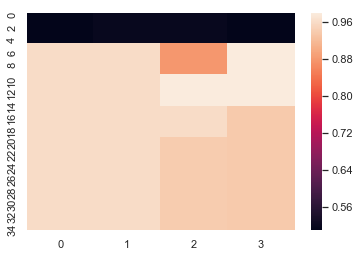

In [277]:
from sklearn.svm import SVC

c_list = (0.01, 0.1, 1, 10, 50, 100, 200)
gamma_list = ( 0.001, 0.01, 0.1, 1, 10)

def score_svm(c, g, cv=4, param_grid={}):
    clf = SVC(C=c, gamma=g)
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv)
    grid_search.fit(x_train, y_train)
    score = cross_val_score(grid_search, x_test, y_test, cv=cv)
    return score

score_list = []
for c in c_list:
    score_value = score_svm(c, g)
    for g in gamma_list:
        print('c: ' + str(c) + ' g: '+ str(g) + ' --> ' + str(score_value))
        score_list.append(score_value)
        
sns.heatmap(score_list)        

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

In [279]:
# Els millors resultats els tenim per a les combinacions:
# c: 1 g: 0.001 --> [0.96078431 0.96       0.98       0.97959184]
# c: 1 g: 0.01 --> [0.96078431 0.96       0.98       0.97959184]
# c: 1 g: 0.1 --> [0.96078431 0.96       0.98       0.97959184]
# c: 1 g: 1 --> [0.96078431 0.96       0.98       0.97959184]
# c: 1 g: 10 --> [0.96078431 0.96       0.98       0.97959184]

# La variació entre combinacions es significativa. Basta comparar els resultats anteriors amb:
# c: 0.01 g: 0.001 --> [0.50980392 0.52       0.52       0.51020408]
# c: 0.01 g: 0.01 --> [0.50980392 0.52       0.52       0.51020408]
# c: 0.01 g: 0.1 --> [0.50980392 0.52       0.52       0.51020408]
# c: 0.01 g: 1 --> [0.50980392 0.52       0.52       0.51020408]
# c: 0.01 g: 10 --> [0.50980392 0.52       0.52       0.51020408]

# Sembla que c té més influència que g. Podem veure que per a c=1, tenim el mateix resultat per als valos de 
#  g = (0.001 .. 10)

# Sí sembla que era d'esperar. Per al nostre dataset on hi ha valors de diferentes clases diferènciades però properes, 
#   és lògic que no afecti gaire la distància entre punts (només on casi se junten). El compromís entre la separació 
#   entre hiperplans i classificació és més determinant si els conjunts estan tan junts.
#   

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el <i>dataset</i> de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

Accuracy: 0.97


array([[95,  2],
       [ 4, 99]], dtype=int64)

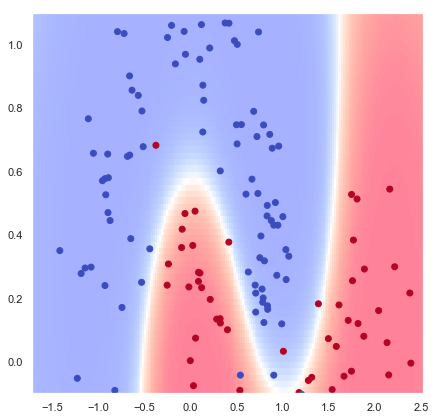

In [281]:
# Podem veure la frontera de decisió
param_grid = {} 
clf = SVC(C=1, gamma=1, probability=True)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=4)
grid_search.fit(x_train, y_train)
plot_decision_boundaries(x_test[:,0], x_test[:,1], y_test, grid_search)

# Obtenim l'accuracy; podem veure que és del 97%
y_pred = grid_search.predict(x_test)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

# Podem veure a la matriu de confusió com només 6 elements de 200 han estat clasificats de forma incorrecta
confusion_matrix(y_test, y_pred)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

In [282]:
# Sembla que la frontera de decisió és més "suau" que en el cas anterior i s'adapta millor al conjunt de dades.
# Tenim un percentatge d'elements ben classificats del 97%; només 6 casos són erronis. 

## 3. Arbres de decisió (1 punt)

En aquest tercer exercici classificarem els punts utilitzant un arbre de decisió. Utilitzarem com abans una cerca de reixeta (*grid search*) per ajustar els hiperparàmetres. En aquest cas ajustarem els següents:

- max_depth: la profunditat màxima de l'arbre. Explorarem els valors entre 4 i 10. 
- min_samples_split: el mínim nombre d'observacions que ha de tenir una fulla de l'arbre per poder-se dividir. Explorarem els valors: 2, 10, 20, 50 i 100.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>max_depth</i> i <i>min_samples_split</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i DecisionTreeClassifier de sklearn.
</div>

 min_samples_split 2 max_depth 4 --> [0.8627451  0.86       0.88       0.75510204]
 min_samples_split 10 max_depth 4 --> [0.88235294 0.86       0.9        0.75510204]
 min_samples_split 20 max_depth 4 --> [0.88235294 0.86       0.9        0.83673469]
 min_samples_split 50 max_depth 4 --> [0.88235294 0.9        0.94       0.83673469]
 min_samples_split 100 max_depth 4 --> [0.80392157 0.84       0.84       0.75510204]
 min_samples_split 2 max_depth 5 --> [0.96078431 0.92       0.94       0.83673469]
 min_samples_split 10 max_depth 5 --> [0.96078431 0.94       0.96       0.75510204]
 min_samples_split 20 max_depth 5 --> [0.96078431 0.86       0.96       0.83673469]
 min_samples_split 50 max_depth 5 --> [0.88235294 0.9        0.94       0.83673469]
 min_samples_split 100 max_depth 5 --> [0.80392157 0.84       0.84       0.75510204]
 min_samples_split 2 max_depth 6 --> [0.96078431 0.92       0.94       0.83673469]
 min_samples_split 10 max_depth 6 --> [0.96078431 0.94       0.96       0.755

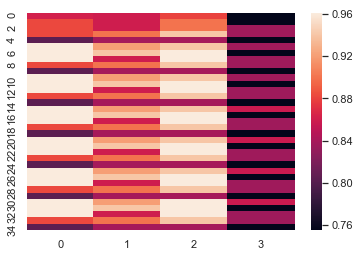

In [299]:
from sklearn.tree import DecisionTreeClassifier
c_min_samples = (2, 10, 20, 50, 100)

def score_tree(d, s, cv=4, param_grid={}):
    clf = DecisionTreeClassifier(random_state=None, max_depth=d, min_samples_split=s)
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv)
    grid_search.fit(x_train, y_train)
    score = cross_val_score(grid_search, x_test, y_test, cv=cv)
    return score

score_list = []
for max_depth in range(4,11):
    for samples in c_min_samples:
        score = score_tree(max_depth, samples)
        score_list.append(score)
        print(' min_samples_split ' + str(samples) + ' max_depth ' + str(max_depth) + ' --> ' + str(score))
        
sns.heatmap(score_list)           

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

In [302]:
# Sembla que el millor cas és:
#   min_samples_split 2 max_depth 10 --> [0.96078431 0.92       0.96       0.85714286]

# Sí, hi ha diferències significatives entre paràmetres. Hi ha casos clarament pitjors, com:
#   min_samples_split 2 max_depth 4 --> [0.8627451  0.86       0.88       0.75510204]

# Els dos paràmetres influeixen de forma similar, malgrat que hi ha combinacions molt iguals. Com a norma general, sembla
#   que com major sigui la profuntitat de l'arbre i menor el nombre de valors mínims d'una fulla per a poder dividir-se, 
#   millor classifica.

# Sí que era d'esperar: com major sigui la profunditat de l'arbre, major capacitat de divisió. El mateix passa si 
#   reduïm el nombre mínim que ha de tenir un node per a poder dividir-se.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'accuracy i la matriu de confusió.
</div>

Accuracy: 0.97


array([[ 94,   3],
       [  3, 100]], dtype=int64)

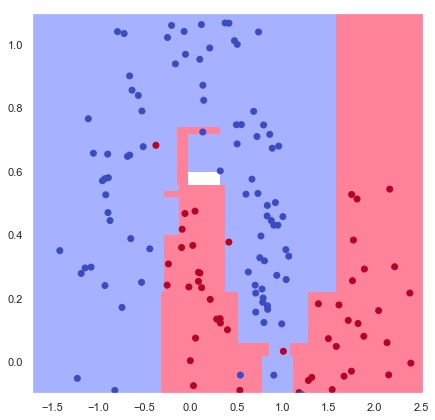

In [303]:
# Podem veure la frontera de decisió
param_grid = {} 
clf = DecisionTreeClassifier(random_state=None, max_depth=10, min_samples_split=2)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=4)
grid_search.fit(x_train, y_train)
plot_decision_boundaries(x_test[:,0], x_test[:,1], y_test, grid_search)

# Obtenim l'accuracy; podem veure que és del 97%
y_pred = grid_search.predict(x_test)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

# Podem veure a la matriu de confusió com només 6 elements de 200 han estat clasificats de forma incorrecta
confusion_matrix(y_test, y_pred)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

In [304]:
# Sembla que la frontera de decisió és molt lineal (és lògic si tenim en ment com funciona un arbre de decisió, que 
#   talla qualsevol espai en dos sub-espais)
# Tenim un percentatge d'elements ben classificats del 97%; només 6 casos són erronis. A diferència del cas anterior, 
#   tenim els mateixos elements mal classificat a ambues classes.

## 4. Random forest (1 punt)

En aquest quart punt classificarem els punts utilitzant un Random forest. Utilitzarem, com fins ara, una cerca de reixeta (*grid search*) per ajustar els hiperparàmetres i ajustarem:

- max_depth: la profunditat màxima de l'arbre. Explorarem els valors entre 6 i 12. 
- n_estimators: nombre d'arbres. Explorarem els valors: 10, 50, 100 i 200.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>max_depth</i> i <i>n_estimators</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i RandomForestClassifier de sklearn.
</div>

 num_estimators 10 max_depth 6 --> [0.92156863 0.92       0.98       0.93877551]
 num_estimators 50 max_depth 6 --> [0.96078431 0.96       0.96       0.89795918]
 num_estimators 100 max_depth 6 --> [0.96078431 0.94       1.         0.91836735]
 num_estimators 200 max_depth 6 --> [0.96078431 0.94       0.98       0.91836735]
 num_estimators 10 max_depth 7 --> [0.96078431 0.94       0.98       0.93877551]
 num_estimators 50 max_depth 7 --> [0.96078431 0.96       0.96       0.95918367]
 num_estimators 100 max_depth 7 --> [0.96078431 0.94       0.96       0.95918367]
 num_estimators 200 max_depth 7 --> [0.96078431 0.94       0.96       0.95918367]
 num_estimators 10 max_depth 8 --> [0.94117647 0.94       1.         0.87755102]
 num_estimators 50 max_depth 8 --> [0.96078431 0.94       1.         0.95918367]
 num_estimators 100 max_depth 8 --> [0.96078431 0.94       1.         0.95918367]
 num_estimators 200 max_depth 8 --> [0.96078431 0.94       0.98       0.95918367]
 num_estimators 10 max

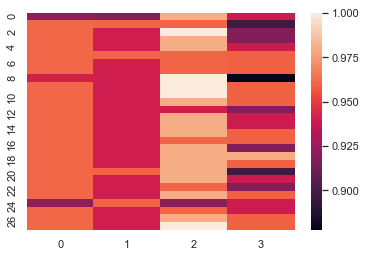

In [307]:
from sklearn.ensemble import RandomForestClassifier
c_estimators = (10, 50, 100, 200)

def score_rf_tree(d, e, cv=4, param_grid={}):
    clf = RandomForestClassifier(random_state=None, max_depth=d, n_estimators=e)
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv)
    grid_search.fit(x_train, y_train)
    score = cross_val_score(grid_search, x_test, y_test, cv=cv)
    return score

score_list = []
for max_depth in range(6,13):
    for num_estimators in c_estimators:
        score = score_rf_tree(max_depth, num_estimators)
        score_list.append(score)
        print(' num_estimators ' + str(num_estimators) + ' max_depth ' + str(max_depth) + ' --> ' + str(score))
        
sns.heatmap(score_list) 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

In [309]:
# No hi ha una única combinació que doni un millor resultat. Per exemple:
#  num_estimators 50 max_depth 8 --> [0.96078431 0.94       1.         0.95918367]
#  num_estimators 200 max_depth 12 --> [0.96078431 0.94       1.         0.95918367]

# Sí és significativa la variació entre combinacions. Com a norma general, sembla molt lògic que la qualitat del model 
#  millori a mida que s'incrementi la profunditat de l'arbre i el nombre d'arbres generats. 

# La profuntitat pot afectar un poc més que el nombre d'arbres generats (sembla lògic que si no s'encerta amb 100 
#  arbres, tampoc se faci amb 200) però ambdues variables són rellevants.

# És d'esperar que com més nivells i més arbres es generin, millor serà la qualitat de l'arbre.
# A partir d'uns valors suficientment alts, no hi ha grans diferències.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

Accuracy: 0.98


array([[ 95,   2],
       [  2, 101]], dtype=int64)

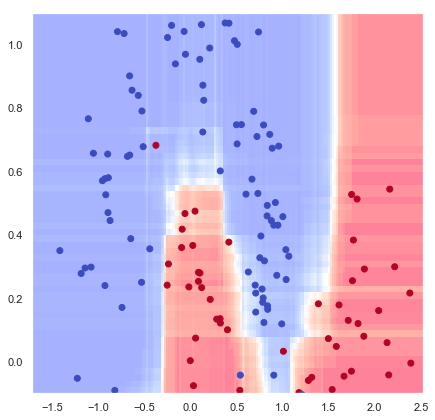

In [319]:
# Podem veure la frontera de decisió
param_grid = {} 
clf = RandomForestClassifier(max_depth=8, n_estimators=50)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=4)
grid_search.fit(x_train, y_train)
plot_decision_boundaries(x_test[:,0], x_test[:,1], y_test, grid_search)

# Obtenim l'accuracy; podem veure que és del 97%
y_pred = grid_search.predict(x_test)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

# Podem veure a la matriu de confusió com només 6 elements de 200 han estat clasificats de forma incorrecta
confusion_matrix(y_test, y_pred)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

In [320]:
# El comportament és molt similar al d'un arbre. La forma és semblant, però un poc més afinada. Les divisions 
#   es troben un poc més difuminades (ja que no és un únic arbre, sino la combinació de 50)
# Tenim un percentatge d'elements ben classificats del 98%; només 4 casos són erronis. Igual que en el cas anterior, 
#   tenim els mateixos elements mal classificat a ambues classes.

## 5. Gradient boosting (1 punt)

En aquest exercici classificarem els punts utilitzant un Gradient boosting. Utilitzarem com fins ara una cerca de reixeta (*grid search*) per ajustar els següents hiperparàmetres:

- learning_rate: velocitat d'aprenentatge, si el valor és molt alt correm el risc que explori massa i no trobi cap òptim, mentre que si el valor és molt baix pot tardar molt en convergir i estancar-se en un mínim local. Explorarem els valors: 0.01, 0.1, 1 i 2. 
- n_estimators: nombre d'arbres. Explorarem els valors: 10, 50, 100 i 200.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>learning_rate</i> i <i>n_estimators</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i GradientBoostingClassifier de sklearn.
</div>

 learning_rate 0.01 estimators 10 --> [0.88235294 0.9        0.94       0.75510204]
 learning_rate 0.01 estimators 50 --> [0.88235294 0.92       0.94       0.83673469]
 learning_rate 0.01 estimators 100 --> [0.96078431 0.94       0.96       0.87755102]
 learning_rate 0.01 estimators 200 --> [0.96078431 0.96       0.96       0.87755102]
 learning_rate 0.1 estimators 10 --> [0.96078431 0.94       0.96       0.87755102]
 learning_rate 0.1 estimators 50 --> [0.96078431 0.94       0.98       0.95918367]
 learning_rate 0.1 estimators 100 --> [0.96078431 0.96       0.94       0.93877551]
 learning_rate 0.1 estimators 200 --> [0.96078431 0.94       0.94       0.93877551]
 learning_rate 1 estimators 10 --> [0.96078431 0.96       0.94       0.93877551]
 learning_rate 1 estimators 50 --> [0.96078431 0.96       0.94       0.93877551]
 learning_rate 1 estimators 100 --> [0.96078431 0.96       0.94       0.93877551]
 learning_rate 1 estimators 200 --> [0.96078431 0.96       0.94       0.93877551]
 l

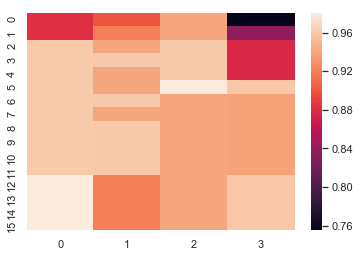

In [323]:
from sklearn.ensemble import GradientBoostingClassifier

c_learning_rate = (0.01, 0.1, 1, 2)
c_estimators = (10, 50, 100, 200)

def score_gradient_boosting(l, e, cv=4, param_grid={}):
    clf = GradientBoostingClassifier(random_state=None, learning_rate=l, n_estimators=e)
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv)
    grid_search.fit(x_train, y_train)
    score = cross_val_score(grid_search, x_test, y_test, cv=cv)
    return score

score_list = []
for lr in c_learning_rate:
    for e in c_estimators:
        score = score_gradient_boosting(lr, e)
        score_list.append(score)
        print(' learning_rate ' + str(lr) + ' estimators ' + str(e) + ' --> ' + str(score))
        
sns.heatmap(score_list)   

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

In [324]:
# Una combinació que ha funcionat molt bé és: 
#  learning_rate 0.1 estimators 50 --> [0.96078431 0.94       0.98       0.95918367]

# La diferència no és molt significativa si no tenim en compte els valors inferiors. Com a exemple, podem veure
#  que el nombre d'arbres és irrellevant si el learning_rate = 2:
#    learning_rate 2 estimators 10 --> [0.98039216 0.92       0.94       0.95918367]
#    learning_rate 2 estimators 50 --> [0.98039216 0.92       0.94       0.95918367]
#    learning_rate 2 estimators 100 --> [0.98039216 0.92       0.94       0.95918367]
#    learning_rate 2 estimators 200 --> [0.98039216 0.92       0.94       0.95918367]

# De la mateixa manera, si el nombre d'arbres és prou alt, la velocitat d'aprenentatge tampoc és molt important. Per 
#   exemple, veim que les variacions són mínimes a:
#    learning_rate 0.1 estimators 200 --> [0.96078431 0.94       0.94       0.93877551]
#    learning_rate 1 estimators 200 --> [0.96078431 0.96       0.94       0.93877551]

# Sí que era d'eperar. Sembla clar que a major temps d'aprenentatge i a major nombre d'arbres, millor és el classificador
# A partir d'uns valors suficientment alts, no hi ha grans diferències.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

Accuracy: 0.975


array([[ 94,   3],
       [  2, 101]], dtype=int64)

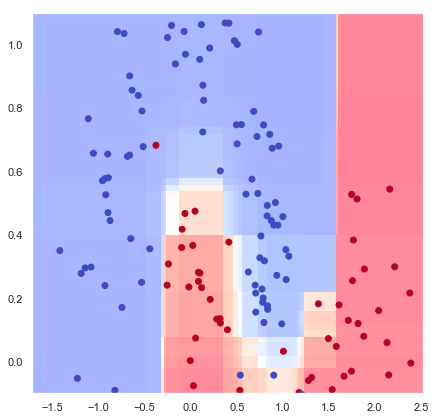

In [334]:
# Podem veure la frontera de decisió
param_grid = {} 
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=4)
grid_search.fit(x_train, y_train)
plot_decision_boundaries(x_test[:,0], x_test[:,1], y_test, grid_search)

# Obtenim l'accuracy; podem veure que és del 97%
y_pred = grid_search.predict(x_test)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

# Podem veure a la matriu de confusió com només 6 elements de 200 han estat clasificats de forma incorrecta
confusion_matrix(y_test, y_pred)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

In [ ]:
# El comportament és molt similar al d'un arbre. La forma és semblant, però un poc més afinada. Les divisions 
#   es troben un poc més difuminades (ja que no és un únic arbre, sino la combinació de 50)
# Tenim un percentatge d'elements ben classificats del 97.5%; només 5 casos són erronis. 

## 6. Xarxes neuronals (5 punts)

Per al últim exercici utilitzarem una xarxa neuronal per a classificar els punts. En aquest cas, en lloc d'utilitzar una cerca de reixeta per ajustar els hiperparàmetres de l'algoritme utilitzarem una cerca aleatòria, és a dir, provarem combinacions de paràmetres a l'atzar.

### 6a. Xarxes neuronals sense capa oculta

Per aquest primer apartat, utilitzarem una xarxa monocapa amb 2 sortides (una per a cada classe del conjunt de dades: punts blaus, punts vermells) entrenada amb el mètode de retropropagació i l'optimitzador SGD. En primer lloc entrenarem una xarxa neuronal sense capa oculta. Els hiperparàmetres a ajustar en aquest cas són els següents:

- Número d'èpoques d'entrenament: provarem valors entre 10 y 150.
- Velocitat d'aprenentatge (*learning rate*): provarem valors entre 0.01 y 1.

El procediment per a validar el rendiment del model per a cada combinació de paràmetres serà el mateix que en els casos anteriors: validació creuada amb 4 particions generades de forma estratificada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Càlcul del valor òptim del número d'èpoques d'entrenament i la velocitat d'aprenentatge utilitzant 20 combinacions de paràmetres triades a l'atzar. Podeu utilitzar els mòduls Sequential, Dense i SGD de keras, així com els mòduls uniform i randint de scipy i StratifiedKFold de sklearn. 
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

### 6b. Xarxes neuronals amb capa oculta

En aquest cas afegirem una capa oculta. Les neurones de la capa oculta trindran com a activació la funció sigmoide. Els hiperparàmetres a ajustar en aquest cas són els següents:

- Número de neurones de la capa oculta: provarem valors entre 2 y 20.
- Número d'èpoques d'entrenament: provarem valors entre 10 y 150.
- Velocitat d'aprenentatge (*learning rate*): provarem valors entre 0.01 y 1.

Com sempre, el procediment per a validar el rendiment del model per a cada combinació de paràmetres serà la validació creuada amb 4 particions generades de forma estratificada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Càlcul del valor òptim del número de neurones de la capa oculta, el número d'èpoques d'entrenament i la velocitat d'aprenentatge utilitzant 20 combinacions de paràmetres triades a l'atzar. Podeu utilitzar els mòduls Sequential, Dense i SGD de keras, així com els mòduls uniform i randint de scipy i StratifiedKFold de sklearn.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quins paràmetres han donat millors resultats? Quina variació hi ha entre les diferents combinacions de paràmetres? És significativa la variació entre les diferents combinacions? Hi ha cap paràmetre que tingui més influència que l'altre? Era d'esperar?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

### 6c. Optimizació de mètriques

En els exercicis anteriors hem buscat sempre el model que obté millor precisió en general, però aquesta no és sempre l'opció més adequada. Per exemple, imaginem que els punts blaus corresponen a tumors malignes, mentre que els vermells corresponen a tumors benignes. Un metge necessita no equivocar-se al classificar un tumor maligne, ja que si no s'actua a temps les conseqüències poden ser nefastes. Per tant un metge necessita no equivocar-se en la classificació dels punts blaus (assumint si es necessari que per aconseguir-ho hi haurà tumors benignes que seràn erròniament classificats com a malignes).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> Utilitzant els hiperparàmetres amb major precisió obtinguts a l'apartat anterior, utilitzeu el paràmetre <i>class_weight</i> per donar més pes a la classificació de punts blaus. Representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>